# Exploring Text on Maps

This notebook provides some examples of how to load and visualise the text outputs of MapReader. 

We focus on the geogrpaphy of railspace.

----

In [2]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
import plotly.express as px
from ast import literal_eval
from collections import Counter
from tqdm import tqdm

# Load data

In [188]:
# Load the patch predictions for railspace and railspace + buildings (codes 01 and 03)
predictions = geopd.read_file("/Users/kasparbeelen/Documents/LwM/imago-mundi/mapreader_maptext_outputs/MapReader_Data_SIGSPATIAL_2022/outputs/label_01_03/pred_01_03_keep_01_0250.csv")
predictions.head(3)

,field_1,center_lon,center_lat,pred,conf,mean_pixel_RGB,std_pixel_RGB,mean_pixel_A,image_id,parent_id,pub_date,url,x,y,z,opening_year_quicks,closing_year_quicks,dist2quicks,geometry
0,0,-0.4011055106547341,52.61260776720805,1,0.9898980855941772,0.8450341820716858,0.1668068021535873,1.0,patch-3014-0-3151-137-#map_100890251.png#.PNG,map_100890251.png,1902,https://maps.nls.uk/view/100890251,3880925.8529841416,-27169.29919979412,5044483.051365171,1867,1929,1121.9150481268305,None
1,1,-0.399645312864389,52.61260776720805,1,0.9999995231628418,0.823089599609375,0.1925655305385589,1.0,patch-3151-0-3288-137-#map_100890251.png#.PNG,map_100890251.png,1902,https://maps.nls.uk/view/100890251,3880926.544140446,-27070.392789791513,5044483.051365171,1867,1929,1113.0714735200893,None
2,2,-0.4011055106547341,52.61171342293056,1,0.998733937740326,0.8648163676261902,0.1285138428211212,1.0,patch-3014-137-3151-274-#map_100890251.png#.PNG,map_100890251.png,1902,https://maps.nls.uk/view/100890251,3881004.9253640324,-27169.852763873692,5044422.621073416,1867,1929,1220.6227775525679,None


In [190]:
# load the gepjson with spotted text
# we use the file that has been converted to point data
spotted_text = geopd.read_file("/Users/kasparbeelen/Documents/LwM/imago-mundi/mapreader_maptext_outputs/geo_predictions_deduplicated_point.json")
spotted_text.head()

,image_id,crs,text,score,patch_id,duplicate,geometry
0,map_95470395.png,EPSG:4326,GARDENS,0.97,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (-0.22055 51.49457)
1,map_95470395.png,EPSG:4326,Soh.,0.96,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (-0.22061 51.49239)
2,map_95470395.png,EPSG:4326,ROAD,0.98,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (-0.22445 51.48863)
3,map_95470395.png,EPSG:4326,STREET,0.97,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (-0.22750 51.49267)
4,map_95470395.png,EPSG:4326,BERYL,0.97,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (-0.22095 51.48860)


In [191]:
# print the shape of the dataframes
print(f"Railspace predictions shape: {predictions.shape}")
print(f"Spotted text shape: {spotted_text.shape}")

Railspace predictions shape: (483278, 19)
Spotted text shape: (463769, 7)


In [195]:
# Retain patch predictions for maps for that are in the spotted text data
text_map_ids = list(spotted_text.image_id.unique())
print('number of maps', len(text_map_ids))

number of maps 329


In [196]:
# filter to one parent map to save time
predictions_with_text = predictions[predictions['parent_id'].isin(text_map_ids)]
predictions_with_text.shape,predictions.shape


((26835, 19), (483278, 19))

In [197]:
# add geometry to the patch predictions
predictions_with_text['geometry'] = geopd.points_from_xy(predictions_with_text.center_lon, predictions_with_text.center_lat)
predictions_with_text.reset_index(drop=True, inplace=True)
predictions_with_text.head(3)

/Users/kasparbeelen/anaconda3/envs/mapreader/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,field_1,center_lon,center_lat,pred,conf,mean_pixel_RGB,std_pixel_RGB,mean_pixel_A,image_id,parent_id,pub_date,url,x,y,z,opening_year_quicks,closing_year_quicks,dist2quicks,geometry
0,82604,0.0054502487182617,51.51405725996779,1,0.9999876022338868,0.7180785536766052,0.1661627292633056,1.0,patch-5304-680-5440-816-#map_101427837.png#.PNG,map_101427837.png,1899,https://maps.nls.uk/view/101427837,3977424.4080393487,378.35164355055997,4969335.908927486,1858,1943,864.2700378881675,POINT (0.00545 51.51406)
1,82605,0.0069093704223632,51.51405725996779,1,0.9997331500053406,0.7427434921264648,0.1574448347091674,1.0,patch-5440-680-5576-816-#map_101427837.png#.PNG,map_101427837.png,1899,https://maps.nls.uk/view/101427837,3977424.397114302,479.642634298165,4969335.908927486,1858,1943,790.1369984878037,POINT (0.00691 51.51406)
2,82606,0.0039911270141601,51.513158932432354,1,0.9893848299980164,0.7143736481666565,0.1780998110771179,1.0,patch-5168-816-5304-952-#map_101427837.png#.PNG,map_101427837.png,1899,https://maps.nls.uk/view/101427837,3977502.6498777936,277.0661021702683,4969273.709528874,1858,1943,887.5020002962651,POINT (0.00399 51.51316)


In [198]:
# convert the projection to the same as the spotted text
predictions_with_text.crs = "epsg:4326"
predictions_with_text.to_crs(epsg=27700, inplace=True)
spotted_text.to_crs(epsg=27700, inplace=True)

/Users/kasparbeelen/anaconda3/envs/mapreader/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The below cell identifies the text that falls within the 100m of building patches. Text within this distance is stored as "adjacent text" and any other text is stored as "other text".

In [111]:
tqdm.pandas()
adjacent_text = [] # here we store labels close to the target category, i.e. building classified as 1

#target_label = "building"
distance = 100 # maximum distance in meters between patch and text centroid

for i,row in tqdm(predictions_with_text.iterrows(), total=predictions_with_text.shape[0]):
    # get text within a certain distance from the patch centroid
    labels = spotted_text[spotted_text.distance(row.geometry) <= distance].text.tolist()
    # if patch is classified as the target label, add text to adjacent_text, otherwise add to other_text
    #if row['predicted_label'] == target_label:
    adjacent_text.extend(labels)
    #else:
    #    other_text.extend(labels)

print('Railspace labels',len(adjacent_text))

100%|██████████| 26835/26835 [54:43<00:00,  8.17it/s] 

Railspace labels 213450


In [199]:
# save the adjacent text to a txt file
with open('adjacent_txt.txt', 'w') as out_txt:
    out_txt.write('\n'.join(adjacent_text))

In [202]:
with open('adjacent_txt.txt', 'r') as in_txt:
    adjacent_text = [i.strip() for i in in_txt.readlines()]
adjacent_text[:10]

['Cooperage',
 'Wharf',
 'Cooperage',
 'Wharf',
 'Sch',
 'Sch',
 'Cooperage',
 'Wharf',
 'Cooperage',
 'Wharf']

In [203]:
all_text = spotted_text.text.tolist()

In [204]:
# get counts and probabilities of the text labels for the building category
railspace_text_freq =  Counter([i.lower() for i in adjacent_text])
railspace_text_prob = {k: v/ sum(railspace_text_freq.values()) for k,v in railspace_text_freq.items()}

In [205]:
# get counts and probabilities of the text labels for the other category
all_text_freq =  Counter([i.lower() for i in all_text])
all_text_prob = {k: v/ sum(all_text_freq.values()) for k,v in all_text_freq.items()}

In [206]:
# compare both absoluate counts and probabilities of a give word
word = 'railway'
print(railspace_text_freq[word], all_text_freq[word])
print(railspace_text_prob[word], all_text_prob[word])

840 298
0.003935347856640899 0.0006425612751175693


In [207]:
# compute the proportional difference
proportional_difference = sorted({w: railspace_text_prob.get(w,0) - all_text_prob.get(w,0) for w in all_text_prob.keys()}.items(), key=lambda x: x[1], reverse=True)


In [208]:
print('Railscape labels')
print(proportional_difference[:5])
print('Other labels')
print(proportional_difference[-5:])

Railscape labels
[('s.', 0.08090059610430334), ('p', 0.04475974460514513), ('&', 0.009451424674718552), ('station', 0.007842019380472411), ('r.', 0.0050581293661980985)]
Other labels
[('wood', -0.006077280294137356), ('lodge', -0.007163498510339925), ('farm', -0.00834608133026841), ('p.', -0.01665808217648658), ('f.', -0.02069281119909323)]


<Axes: title={'center': 'Top 20 terms in Building labels'}, xlabel='Term', ylabel='Difference in probability'>

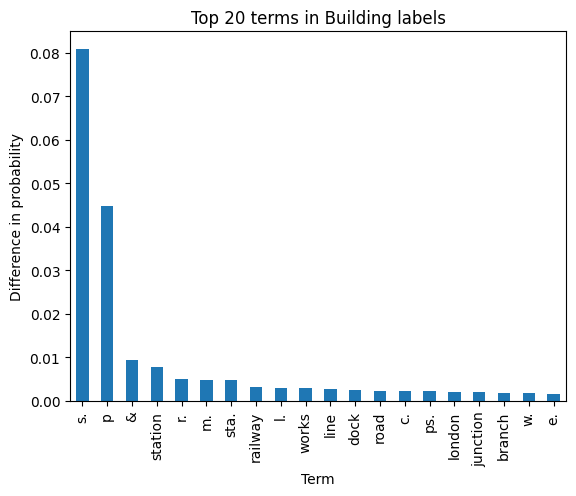

In [212]:
pd.DataFrame(proportional_difference[:20]).plot(kind='bar', x=0, y=1, legend=False, 
                            title='Top 20 terms in Building labels', 
                            xlabel='Term', ylabel='Difference in probability')

<Axes: title={'center': 'Top 20 terms in Other labels'}, xlabel='Term', ylabel='Difference in probability'>

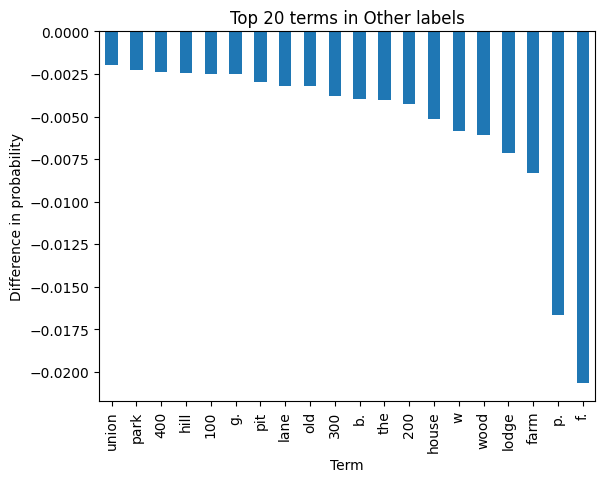

In [211]:
pd.DataFrame(proportional_difference[-20:]).plot(kind='bar', x=0, y=1, legend=False, 
                            title='Top 20 terms in Other labels', 
                            xlabel='Term', ylabel='Difference in probability')

To get a sense of what some of the abbreviations mean, please go to the NLS website: https://maps.nls.uk/os/abbrev/

# Visalizing the semantic of text on maps

In the visualization below we encode each label to a vector using BERT-type language model. This generates a vector for each labels that approximates the 'meaning' of this label. Then we visualize these embeddigns in two dimensional space where you can explore the different semantic regions of the text data.

In [122]:
# uncomment the following line to run if you have not yet installed sentence-transformers, scikit-learn and plotly
#!pip install -U -q sentence-transformers scikit-learn plotly

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import plotly.express as px
from sklearn.metrics.pairwise import cosine_distances

In [214]:
# get all text labels above a certain threshold to obtain the railspace labels
threshold = 0.0001
railspace_labels = [w for w,v in proportional_difference if v > threshold]
len(railspace_labels)

379

In [215]:
# filter labels that are not words properly
railspace_labels = [w for w in railspace_labels if not (w.endswith('#') or w.startswith('#') or w.endswith('>') or w.startswith('<') or w[0].isdigit())] 

In [217]:
# get all other labels based on the inverse of the railspace threshold
other_labels = [w for w,v in proportional_difference if v < threshold*-1]
# filter these labels
other_labels = [w for w in other_labels if not (w.endswith('#') or w.startswith('#') or w.endswith('>') or w.startswith('<') or w[0].isdigit())]

len(other_labels)

221

In [218]:
# embed the railspace labels
# load pre-trained sentence transformer model
# if you are working with a different language, you can change the model to a multilingual one
# please refer to the documentation for more information: https://www.sbert.net/docs/pretrained_models.html
# you can plug in the BLERT model here
model = SentenceTransformer('distilbert-base-nli-mean-tokens') # Livingwithmachines/bert_1760_1900

# encode the sentences
railspace_sentence_embeddings = model.encode(railspace_labels)

# perform dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(railspace_sentence_embeddings)

In [219]:
# visualize the labels in 2D scatter plot using the probability difference as size
data = pd.DataFrame(embeddings_tsne, columns=['x','y'])
data['text'] = railspace_labels
data['size'] = [(dict(proportional_difference)[w]+.1)**2 for w in railspace_labels]
fig = px.scatter(data, x="x", y="y", text='text', size='size', width=1000, height=1000,)
fig.show()

In [223]:
# create a railspaces embedding, feel free to add other labels
railspace_sentence_embeddings
railspace = model.encode(['rail train'])

In [224]:
# compute the cosine distance between the railspaces labels and the labels
data['sem_dist_to_rail'] = cosine_distances(railspace_sentence_embeddings, railspace.reshape(1, -1))

In [184]:
data.sort_values('sem_dist_to_rail').head(20)

,x,y,text,size,sem_dist_to_rail
7,11.050068,5.982724,railway,0.010669,0.107692
75,10.789123,5.570088,rail,0.010080,0.142035
3,9.911406,6.197133,station,0.011630,0.231325
209,12.894039,7.578224,carriage,0.010026,0.293032
236,11.008500,8.657470,siding,0.010022,0.318597
30,9.278534,7.922123,depot,0.010203,0.319913
89,9.278534,7.922123,depöt,0.010064,0.319913
153,11.056243,8.618883,sidings,0.010036,0.326942
204,10.405899,3.443683,railrny,0.010027,0.350889
16,8.525537,5.658059,junction,0.010403,0.366471


In [185]:
#data.sort_values('sem_dist_to_rail').tail(30)

In [186]:
other_sentence_embeddings = model.encode(other_labels)


In [187]:
pd.DataFrame.from_records([other_labels,
              list(cosine_distances(other_sentence_embeddings, railspace.reshape(1, -1)).reshape(-1))],
              ).T.sort_values(1).head(20)

,0,1
147,mount,0.428515
37,highfield,0.43671
86,rookery,0.442314
84,room,0.464251
167,chapel,0.467283
151,court,0.469564
36,coppice,0.469885
18,hurst,0.47321
43,bed,0.473819
88,shaft,0.476284
